# An introduction to explainable AI with Shapley values
- [Examples on using Shapley values from SHAP's own site](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) using the Python `shap` package
- Shapley allows you to explain ML models

## Explaining a Linear Regression Model
- import the California Housing Dataset with data on 20,640 house prices and details from California in 1990
- use a [Scikit Learn Linear Regression](https://scikit-learn.org/1.7/modules/generated/sklearn.linear_model.LinearRegression.html) to predict the natural log of the median home price
- this is basically just doing a curve fit minimizing the least squares error
- 8 features:

| feature | column | meaning |
| --- | --- | --- |
| 1 | MedInc     | median income in block group             |
| 2 | HouseAge   | median house age in block group          |
| 3 | AveRooms   | average number of rooms per household    |
| 4 | AveBedrms  | average number of bedrooms per household |
| 5 | Population | block group population                   |
| 6 | AveOccup   | average number of household members      |
| 7 | Latitude   | block group latitude                     |
| 8 | Longitude  | block group longitude                    |

In [53]:
import sklearn
import shap

# import 1000 points from the California Housing Price Dataset and sample 100 of the points
X, y = shap.datasets.california(n_points=1000)
# sample 100 points for use as the background distribution
X100 = shap.utils.sample(X, 100)  

# fit a simple linear regression model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

# determine the prediction equation from the coefficients that were fitted
terms = []
for c,p in zip(model.coef_, X.columns):
    s = "" if c < 0 else "+"
    term = f"{s}{c:.5f} {p}".replace("+", "+ ").replace("-", "- ")
    terms.append(term)
eqn = f"\n{' ' * 20}".join(terms)
print(f"ln(MedHousePrice) = {eqn}")

ln(MedHousePrice) = + 0.42563 MedInc
                    + 0.01033 HouseAge
                    - 0.11610 AveRooms
                    + 0.66385 AveBedrms
                    + 0.00003 Population
                    - 0.26096 AveOccup
                    - 0.46734 Latitude
                    - 0.46272 Longitude


### Limitations of Coefficients
- examining the coefficients can tell us what will happen if we change one of the inputs
    - for instance, we can see that `AveBedrms` is the largest coefficient
    - so adding a bedroom will have a greater impact on price than adding one `MedInc`
- but they are not great at telling the overall importance of a features
    - the coefficients are **dependent on the scale** of the features
    - if `HouseAge` was recorded in minutes instead of years, its coefficient would drop
    - the new coefficient would be $0.01033 / (365 * 24 * 60) = 1.97e^{-8}$

### Partial Dependence Plot
- we can build a partial dependence plot to look at the distribution of a feature as a histogram on the x-axis

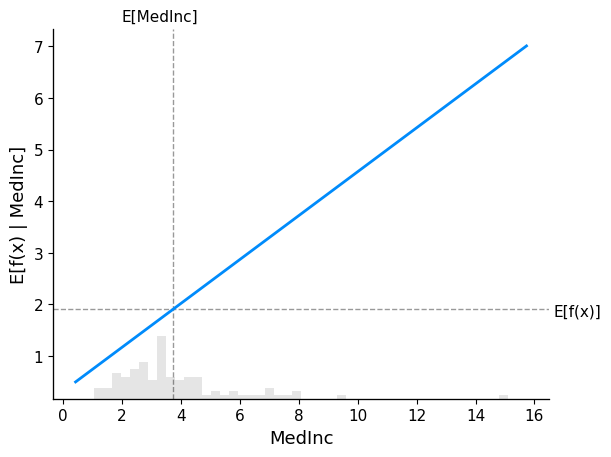

In [ ]:
shap.partial_dependence_plot(
    "MedInc", # will plot the dependence of the fitted model on the "MedInc" (Median Income) feature
    model.predict, # pass it the prediction function of the model for it to use
    X100, # will predict the ln(Median House Price) at the 100 sampled points
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

- `E[f(x)]` (horizontal) = expected value of the model when applied to the California Housing Dataset
- `E[MedInc]` (vertical) = average value of the `MedInc` feature (something like `3.8`)
- `blue line` (diagonal) = partial dependence (average value of the model output when we fix the `MedInc` feature to a given value)
- we can see the distribution of `MedInc` with the gray histogram at the bottom axis (big spike at about `3.5`)
- and we can see that as `MedInc` increases from`~1.1-16`, the effect increases as well

### Reading SHAP values from partial dependence plots
- Shapley values use fair allocation results from cooperative **game theory** to allocate credit for the models output ($f(x)$) among its input features
- to connect game theory with machine learning models
    - match the model's input features to players in a game
    - match the model function with the rules of the game
- in game theory a player can choose to "join" or "not join" a game
    - need a way for a feture to "join" or "not join" a model
    - common definition: a feature has "joined a model" when we know the feature's value
    - it has "not joined" when we don't know the feature's value
- to evaluated an existing model $f$ when only a subset $S$ of it's total features are known
    - integrate out the other features using one of two conditional expected value formations
        - $E[f(X) | X_s =  x_s]$
            - know the values of the features in $S$ because we *observe* them
        - $E[f(X) | do( X_s =  x_s )]$
            - know the values of the featrues in $S$ because we *set* them 
            - this method is preferred, and is used exclusively in this tutorial
            - tells us how the model would behave if we intervened and changed its inputs
            - much easier to compute
- SHAP values can be very complicated to calculate
    - linear models are very simple to calculate - can read right off the SHAP chart
        - explain the prediction $f(x)$
        - the SHAP value for a specific feature $i$ is just the difference between:
            - expected model output
            - partial dependence plot at feature's value $x_i$


ExactExplainer explainer: 1001it [00:19, 50.20it/s]                          


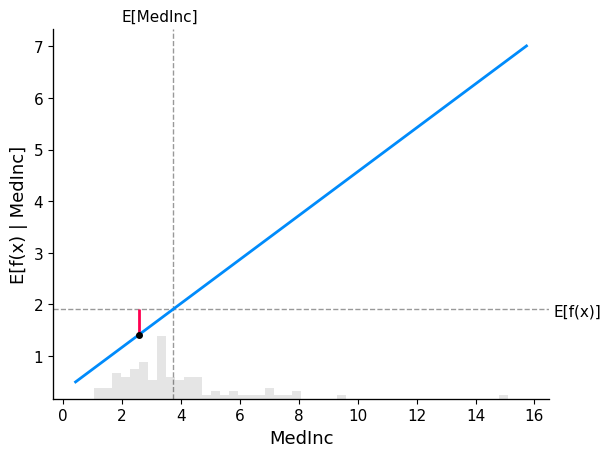

In [56]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

- so that red line is the SHAP value for MedInc?
    - x-axis: $MedInc$ = value of the Median Income feature with a histogram of the distributions
    - y-axis: $E[f(x)|MedInc]$
    - horizontal line: $E[f(x)]$
    - vertical line: $E[MedInc]$

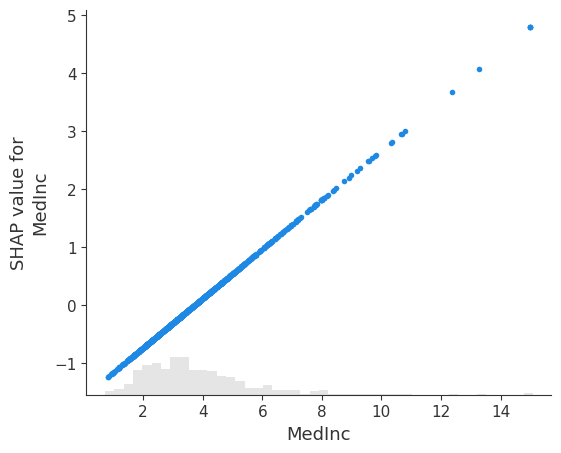

In [ ]:
# plot the SHAP values for MedInc for each dataset points
# traces out the mean centerd version of the partial dependence plot for that feature
shap.plots.scatter(shap_values[:, "MedInc"])